In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['CUDA_VISIBLE_DEVICES']='1'
    
import pandas as pd
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the tensors

In [3]:
data = torch.load('ADNI_PET', map_location='cpu')

In [4]:
print(f"There are {data['data'].shape[0]} visits with a total of {data['data'].shape[1]*data['data'].shape[2]*data['data'].shape[3]} dimentions")

There are 3473 visits with a total of 614400 dimentions


In [5]:
template_data_path = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI006S0498/ses-M00/deeplearning_prepare_data/image_based/pet_linear/sub-ADNI006S0498_ses-M00_task-rest_acq-fdg_pet_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [6]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data /= template_data.max()
template_data.shape

torch.Size([1, 80, 96, 80])

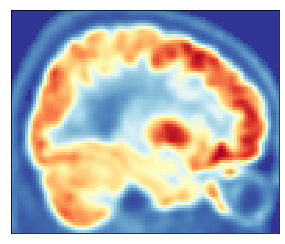

In [7]:
plt.matshow(np.rot90(data['data'][8][55]), cmap='RdYlBu_r')
plt.xticks([])
plt.yticks([])
plt.show()

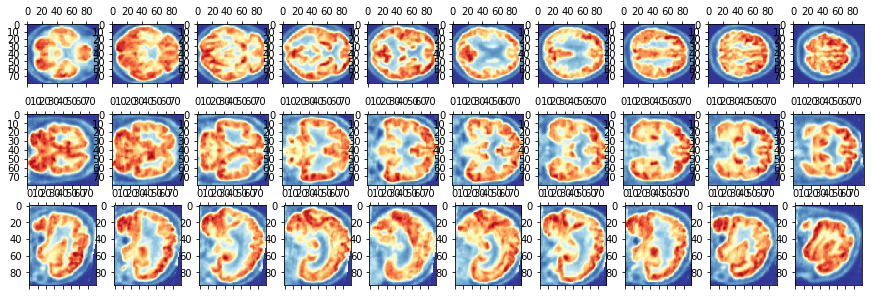

In [8]:
fig, axes = plt.subplots(3,10, figsize=(15,5))


for i in range(10):
    axes[0][i].matshow(template_data[0][:,:,20 + 5*i], cmap='RdYlBu_r')
    axes[1][i].matshow(template_data[0][:,20 + 5*i], cmap='RdYlBu_r')
    axes[2][i].matshow(template_data[0][20 + 5*i], cmap='RdYlBu_r')

#plt.matshow(template_data[0][:,:,40])
plt.show()

In [9]:
caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE', 'sex', 'apoe4']].set_index(['participant_id','session_id'])

caps_info

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


age diagnosis  MMSE sex  apoe4
participant_id   session_id                                 
sub-ADNI002S0295 ses-M00     84.8        CN  28.0   M    1.0
                 ses-M06     85.3        CN  28.0   M    1.0
                 ses-M12     85.8        CN  30.0   M    1.0
                 ses-M24     87.0        CN  29.0   M    1.0
                 ses-M36     87.8        CN  28.0   M    1.0
...                           ...       ...   ...  ..    ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0   F    0.0
                 ses-M12     75.4       NaN   NaN   F    0.0
                 ses-M24     76.4       NaN  30.0   F    0.0
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0   F    NaN
sub-ADNI941S6854 ses-M00     86.2        AD  30.0   M    NaN

[16319 rows x 5 columns]

In [10]:
caps_info['ID'] = [int(sub[-4:]) for sub in caps_info.index.get_level_values(0)]
caps_info = caps_info.set_index('ID')
caps_info = caps_info.rename(columns={'age':'TIME','diagnosis':'diag'})
caps_info

TIME diag  MMSE sex  apoe4
ID                              
295   84.8   CN  28.0   M    1.0
295   85.3   CN  28.0   M    1.0
295   85.8   CN  30.0   M    1.0
295   87.0   CN  29.0   M    1.0
295   87.8   CN  28.0   M    1.0
...    ...  ...   ...  ..    ...
6581  74.4   CN  30.0   F    0.0
6581  75.4  NaN   NaN   F    0.0
6581  76.4  NaN  30.0   F    0.0
6803  75.0  MCI  28.0   F    NaN
6854  86.2   AD  30.0   M    NaN

[16319 rows x 5 columns]

In [11]:
RIDs = [int(sub) for sub in list(data['RID'])]

df = pd.DataFrame(index=RIDs)
df.index.name = 'ID'
df['labels'] = data['labels']
df['TIME'] = data['timepoints']
df['img_idx'] = np.arange(len(df))

In [12]:
df = df.merge(caps_info, on=['ID','TIME'])
df

labels  TIME  img_idx diag  MMSE sex  apoe4
ID                                               
295        0  89.9        0   CN  28.0   M    1.0
413        1  81.4        1   CN  30.0   F    0.0
413        1  83.3        2   CN  30.0   F    0.0
685        2  93.6        3   CN  28.0   F    0.0
685        2  95.6        4   CN  28.0   F    0.0
...      ...   ...      ...  ...   ...  ..    ...
5124    1515  76.7     3468   CN  26.0   F    0.0
5193    1516  72.5     3469   CN  29.0   F    0.0
6052    1517  88.1     3470  MCI  25.0   F    1.0
6068    1518  75.7     3471  MCI  27.0   M    1.0
6345    1519  79.3     3472  MCI  28.0   M    1.0

[3477 rows x 7 columns]

## Load the models

In [13]:
sys.path.append('/home/benoit.sautydechalon/deformetrica')
from deformetrica.core.model_tools.neural_networks.networks import CVAE_3D, VAE_GAN
from deformetrica.support.utilities.general_settings import Settings

import deformetrica as dfca
from deformetrica.core.models import LongitudinalAutoEncoder
from deformetrica.LAE_experiments.fit_longitudinal_auto_encoder import *
from deformetrica.support.utilities.general_settings import Settings

In [14]:
path_CAE = 'output_CVAE_16_PET_15_sources/CVAE_longitudinal'
path_model = 'model_PET.xml'
path_data = 'ADNI_PET'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_parameters = dfca.io.XmlParameters()
xml_parameters._read_model_xml(path_model)
Settings().dimension = 16
Settings().number_of_sources = 15
Settings().device = device
deformetrica = dfca.Deformetrica(output_dir='output', verbosity=logger.level)

Logger has been set to: NOTSET


In [15]:
#torch_data = torch.load(path_data)
image_data = Dataset(data['data'].unsqueeze(1).float(), data['labels'], data['timepoints'])
number_of_subjects = len(np.unique(image_data.labels))

model, dataset, individual_RER = instantiate_longitudinal_auto_encoder_model(logger, path_data, path_CAE=path_CAE,
                                                                    number_of_subjects=number_of_subjects, xml_parameters=xml_parameters)

Loaded 3373 train images and 100 test images
>> Loaded CAE network from output_CVAE_16_PET_15_sources/CVAE_longitudinal
Model has a total of 11535009 parameters
>> Reading 15-source initial modulation matrix from file: output_CVAE_16_PET_15_sources/LongitudinalMetricModel_modulation_matrix.txt
Setting initial onset ages from output_CVAE_16_PET_15_sources/LongitudinalMetricModel_onset_ages.txt file
Setting initial log accelerations from output_CVAE_16_PET_15_sources/LongitudinalMetricModel_log_accelerations.txt file
Initialized the Euclidean metric for latent space
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting initial sources from output_CVAE_16_PET_15_sources/LongitudinalMetricModel_sources.txt file
>> The time shift variance prior degrees of freedom parameter is set to 1520
>> The log-acceleration variance prior degrees o

In [16]:
v0, p0, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []

for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, modulation_matrix)
model.CAE.training = False

Tmin 35 Tmax 120 Update of the spatiotemporalframe: 2390 ms


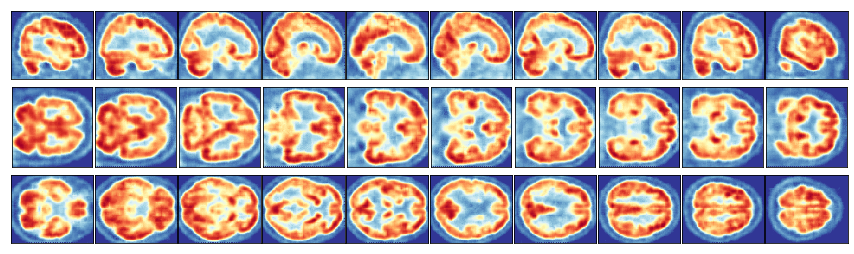

In [17]:
model.CAE.to(device)
_, _, reconstructed = model.CAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(3,10, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[2][i].matshow(reconstructed[0][:,:,20 + 5*i], cmap='RdYlBu_r')
    axes[1][i].matshow(reconstructed[0][:,20 + 5*i], cmap='RdYlBu_r')
    axes[0][i].matshow(np.rot90(reconstructed[0][20 + 5*i]), cmap='RdYlBu_r')

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

In [21]:
ip = pd.DataFrame(index=df.index.unique() ,columns=['onset_age','log_acceleration','s1','s2','s3','s4'])

ip['onset_age'] = individual_RER['onset_age']
ip['log_acceleration'] = individual_RER['log_acceleration']
for i in range(15):
    ip['s'+str(i)] = individual_RER['sources'][:,i]

In [22]:
ip

onset_age  log_acceleration        s1        s2        s3        s4  \
ID                                                                          
295   83.847156         -0.305117 -1.320080 -0.668170 -0.700426  2.001547   
413   80.248423         -0.193523 -0.124175 -0.705255 -0.363623  1.684949   
685   77.178757         -0.386520 -0.954337 -2.087322 -1.478461  0.087969   
729   71.748796         -0.305933 -0.939193 -0.525175  0.417303  1.094490   
1155  65.284398          0.345163 -1.270576 -0.437052  1.055372  0.518929   
...         ...               ...       ...       ...       ...       ...   
5124  78.747208         -0.200979 -0.688455 -0.293300  0.548719 -0.211399   
5193  79.001742         -0.029313 -0.710639 -0.007061  0.252961  0.474559   
6052  81.856971         -0.014844  0.085629  0.509719 -0.638013 -0.315910   
6068  68.386181          0.056507 -0.365337  0.816423  0.001157 -0.680856   
6345  73.438670         -0.046625 -0.124595  0.755527 -0.684843 -0.278905   

            s0        s5        s6        s7        s8        s9       s10  \
ID                                                                           
295   0.904302  0.313088  0.090346 -2.024331 -0.922589  1.358941  0.375106   
413  -1.574253 -1.571792 -0.766475  0.683470  0.076982  0.872154 -0.053935   
685  -0.137920  0.342092  2.082970 -0.725888 -1.384534  1.114447 -1.759117   
729  -1.482943  0.971449  0.523907 -0.557728 -0.107577  1.124878 -0.598601   
1155 -1.633203 -1.401626  0.979389  0.194468  0.276048 -0.924448  0.115779   
...        ...       ...       ...       ...       ...       ...       ...   
5124  0.184860  0.097045 -0.863078 -0.434468  0.623838  0.240929  0.043232   
5193 -0.180318  0.027131 -0.357204 -0.325639  0.460923  0.063508  0.588816   
6052  0.114953  0.441865 -0.172108 -0.162380 -0.946442  0.237706  0.521329   
6068  0.776638 -0.732712  0.178090 -0.163446 -0.108238 -0.180872 -0.429711   
6345  0.032291 -0.436976 -0.528737 -0.115061 -0.516597  0.022143  0.171509   

           s11       s12       s13       s14  
ID                                            
295   1.230826  1.022563  0.040232  0.262035  
413   0.866790 -0.583053  1.540209 -2.029542  
685   1.822570  2.183777  2.370202  1.368726  
729  -0.349721  1.665185  0.391554  0.496657  
1155 -0.099156 -0.852477 -1.283644  0.075835  
...        ...       ...       ...       ...  
5124  0.232624  0.123090 -0.312531 -0.771956  
5193  0.446330  0.793683 -0.529013 -0.699131  
6052 -0.539992 -0.218138 -0.931827 -0.273261  
6068  0.349642  0.160521 -0.271103  0.106491  
6345 -0.611111  0.162842 -0.187415 -0.130160  

[1520 rows x 17 columns]

In [23]:
ip.describe()

onset_age  log_acceleration           s1           s2           s3  \
count  1520.000000      1.520000e+03  1520.000000  1520.000000  1520.000000   
mean     79.153475      2.631579e-09     0.001011     0.001452    -0.000423   
std       8.396576      4.153670e-01     0.998904     0.998991     0.998906   
min      51.151990     -8.413380e-01    -2.409004    -2.496812    -2.499906   
25%      73.554963     -2.657282e-01    -0.720304    -0.702888    -0.684099   
50%      78.894548     -1.316840e-01    -0.004734     0.007577     0.014843   
75%      84.630277      1.161763e-01     0.690774     0.694419     0.709173   
max     106.352052      2.001299e+00     2.513277     2.500806     2.509022   

                s4           s0           s5           s6           s7  \
count  1520.000000  1520.000000  1520.000000  1520.000000  1520.000000   
mean     -0.000741     0.000372    -0.001010    -0.000322     0.000908   
std       0.998912     0.998970     0.998861     0.998877     0.998903   
min      -2.526797    -2.524306    -2.596303    -2.457535    -2.582633   
25%      -0.704921    -0.657370    -0.688780    -0.716483    -0.669666   
50%      -0.027825     0.014216     0.027040    -0.030284     0.020787   
75%       0.675387     0.732078     0.705596     0.667798     0.675377   
max       2.523414     2.380461     2.537562     2.503284     2.513490   

                s8           s9          s10          s11          s12  \
count  1520.000000  1520.000000  1520.000000  1520.000000  1520.000000   
mean     -0.000211    -0.000429     0.000643     0.000240    -0.000760   
std       0.998910     0.998847     0.998985     0.998902     0.998883   
min      -2.400452    -2.493741    -2.423775    -2.492477    -2.577740   
25%      -0.667065    -0.708718    -0.708340    -0.715640    -0.710358   
50%      -0.030171    -0.033049    -0.022387    -0.025967    -0.012174   
75%       0.625160     0.726734     0.687161     0.684555     0.690297   
max       2.588596     2.754598     2.483936     2.507774     2.486469   

               s13          s14  
count  1520.000000  1520.000000  
mean      0.000163     0.000369  
std       0.998939     0.998885  
min      -2.509220    -2.523771  
25%      -0.714048    -0.732525  
50%       0.016813    -0.021587  
75%       0.730960     0.671557  
max       2.370202     2.563508

## Estimation of the MSE

In [18]:
torch.cuda.empty_cache()
model.CAE.training = False

model.CAE.to(device)
test = model.train_images[:30].to(device)

torch.sqrt(((test - model.CAE(test)[2])**2).mean())

RuntimeError: CUDA out of memory. Tried to allocate 564.00 MiB (GPU 0; 7.79 GiB total capacity; 5.71 GiB already allocated; 532.69 MiB free; 5.81 GiB reserved in total by PyTorch)

In [17]:
model.CAE.to(device)
test = model.test_images[:30].to(device)

torch.sqrt(((test - model.CAE(test)[2])**2).mean())

tensor(0.0819, device='cuda:0', grad_fn=<SqrtBackward>)

## Visual QC for reconstruction

In [44]:
template_data = data['data'][66].unsqueeze(0)

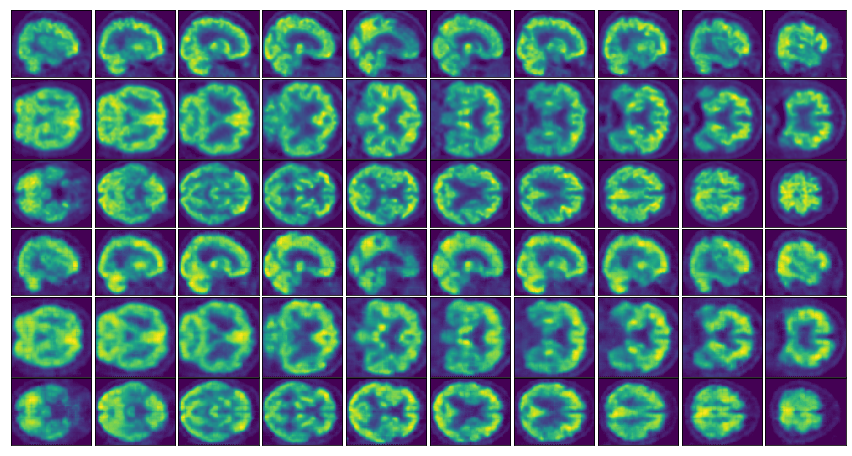

In [45]:
model.CAE.to(device)
_, _, reconstructed = model.CAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(6,10, figsize=(15,8), gridspec_kw={'height_ratios':[.8,.96,.8,.8,.96,.8]})
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[0][i].matshow(np.rot90(template_data[0][20 + 5*i]))
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[2][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[3][i].matshow(np.rot90(reconstructed[0][20 + 5*i]))
    axes[4][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[5][i].matshow(reconstructed[0][:,:,20 + 5*i])
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

## Plotting the geodesic

In [24]:
encoded_images = torch.zeros(2*Settings().number_of_sources+1, 8, Settings().dimension)
source = torch.zeros(Settings().number_of_sources)  
t0 = model.get_reference_time()
#times = [t0+i*7 for i in range(-3,5)]
times = [40, 60, 70, 80, 90, 100, 110, 120]
for i in range(len(times)):
    t = times[i]
    encoded_images[0][i] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))

for i in range(Settings().number_of_sources):
    source = torch.zeros(Settings().number_of_sources)  
    for j in range(2):
        source[i] =  2 * (j - 1/2)
        for idx in range(len(times)):
            encoded_images[2*i+j+1][idx] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([times[idx]]).to(Settings().device),\
                                                                            sources=torch.FloatTensor(source).to(Settings().device))

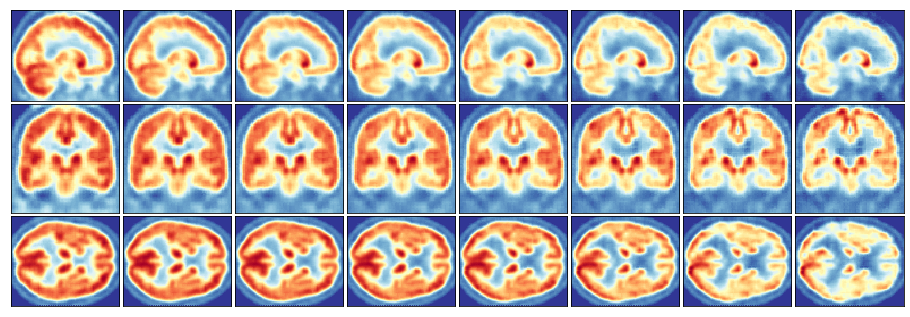

In [25]:
nrows, ncolumns = 3, encoded_images.shape[1]
fig, axes = plt.subplots(3,8, figsize=(16,5.46), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0.03, hspace=0.02)
for j in range(ncolumns):
    simulated_img = model.CAE.decoder(encoded_images[0][j].unsqueeze(0).to(device))
    axes[0][j].matshow(np.rot90(simulated_img[0][0][30].cpu().detach().numpy()), cmap='RdYlBu_r')
    axes[1][j].matshow(np.rot90(simulated_img[0][0][:,44].cpu().detach().numpy()), cmap='RdYlBu_r')
    axes[2][j].matshow(simulated_img[0][0][:,:,40].cpu().detach().numpy(), cmap='RdYlBu_r')
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

## Gradient visualization

In [48]:
encoded_gradient = torch.zeros(Settings().number_of_sources+1, Settings().dimension)

source = torch.zeros(Settings().number_of_sources)  
t0 = model.get_reference_time()
encoded_gradient[0] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0+2]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))

for i in range(Settings().number_of_sources):
    source = torch.zeros(Settings().number_of_sources)  
    source[i] =  1/4
    encoded_gradient[i+1] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0]).to(Settings().device),\
                                                                            sources=torch.FloatTensor(source).to(Settings().device))

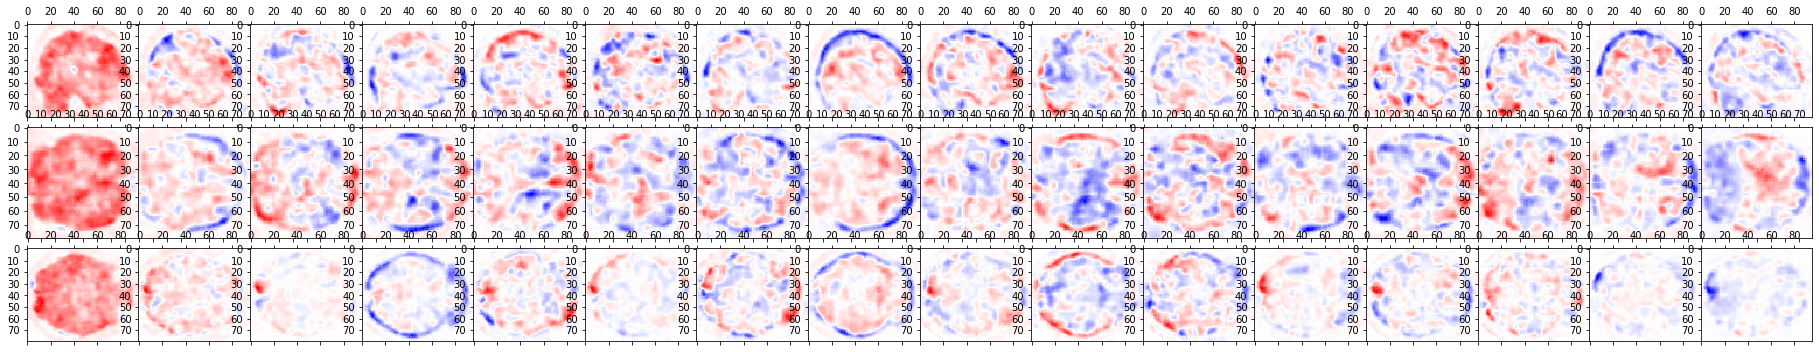

In [49]:
ncolumns = encoded_gradient.shape[0] 
fig, axes = plt.subplots(3, ncolumns, figsize=(2*ncolumns,6), gridspec_kw={'height_ratios':[.8,.96,.8]})
decoded_p0 = model.CAE.decoder(torch.zeros(encoded_gradient[0].shape).unsqueeze(0).to(device))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,ncolumns):
    simulated_img = model.CAE.decoder(encoded_gradient[i].unsqueeze(0).to(device)) - decoded_p0
    axes[0][i].matshow(np.rot90(simulated_img[0][0][58].cpu().detach().numpy()), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=matplotlib.colors.CenteredNorm())
    axes[1][i].matshow(simulated_img[0][0][:,30].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=matplotlib.colors.CenteredNorm())
    axes[2][i].matshow(simulated_img[0][0][:,:,25].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=matplotlib.colors.CenteredNorm())
#for axe in axes:
 #   for ax in axe:
  #      ax.set_xticks([])
   #     ax.set_yticks([])

## Visualization tools for individual parameters

In [26]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [27]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


In [28]:
ip = ip.merge(sub_diag, on='ID')
ip

onset_age  log_acceleration        s1        s2        s3        s4  \
ID                                                                          
295   83.847156         -0.305117 -1.320080 -0.668170 -0.700426  2.001547   
413   80.248423         -0.193523 -0.124175 -0.705255 -0.363623  1.684949   
685   77.178757         -0.386520 -0.954337 -2.087322 -1.478461  0.087969   
729   71.748796         -0.305933 -0.939193 -0.525175  0.417303  1.094490   
1155  65.284398          0.345163 -1.270576 -0.437052  1.055372  0.518929   
...         ...               ...       ...       ...       ...       ...   
5124  78.747208         -0.200979 -0.688455 -0.293300  0.548719 -0.211399   
5193  79.001742         -0.029313 -0.710639 -0.007061  0.252961  0.474559   
6052  81.856971         -0.014844  0.085629  0.509719 -0.638013 -0.315910   
6068  68.386181          0.056507 -0.365337  0.816423  0.001157 -0.680856   
6345  73.438670         -0.046625 -0.124595  0.755527 -0.684843 -0.278905   

            s0        s5        s6        s7        s8        s9       s10  \
ID                                                                           
295   0.904302  0.313088  0.090346 -2.024331 -0.922589  1.358941  0.375106   
413  -1.574253 -1.571792 -0.766475  0.683470  0.076982  0.872154 -0.053935   
685  -0.137920  0.342092  2.082970 -0.725888 -1.384534  1.114447 -1.759117   
729  -1.482943  0.971449  0.523907 -0.557728 -0.107577  1.124878 -0.598601   
1155 -1.633203 -1.401626  0.979389  0.194468  0.276048 -0.924448  0.115779   
...        ...       ...       ...       ...       ...       ...       ...   
5124  0.184860  0.097045 -0.863078 -0.434468  0.623838  0.240929  0.043232   
5193 -0.180318  0.027131 -0.357204 -0.325639  0.460923  0.063508  0.588816   
6052  0.114953  0.441865 -0.172108 -0.162380 -0.946442  0.237706  0.521329   
6068  0.776638 -0.732712  0.178090 -0.163446 -0.108238 -0.180872 -0.429711   
6345  0.032291 -0.436976 -0.528737 -0.115061 -0.516597  0.022143  0.171509   

           s11       s12       s13       s14 diag label  
ID                                                       
295   1.230826  1.022563  0.040232  0.262035   CN     0  
413   0.866790 -0.583053  1.540209 -2.029542   CN     0  
685   1.822570  2.183777  2.370202  1.368726   CN     0  
729  -0.349721  1.665185  0.391554  0.496657   AD     2  
1155 -0.099156 -0.852477 -1.283644  0.075835  MCI     1  
...        ...       ...       ...       ...  ...   ...  
5124  0.232624  0.123090 -0.312531 -0.771956   CN     0  
5193  0.446330  0.793683 -0.529013 -0.699131   CN     0  
6052 -0.539992 -0.218138 -0.931827 -0.273261  MCI     1  
6068  0.349642  0.160521 -0.271103  0.106491  MCI     1  
6345 -0.611111  0.162842 -0.187415 -0.130160   AD     2  

[1520 rows x 19 columns]

<AxesSubplot:>

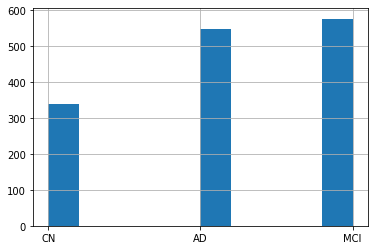

In [29]:
ip['diag'].hist()

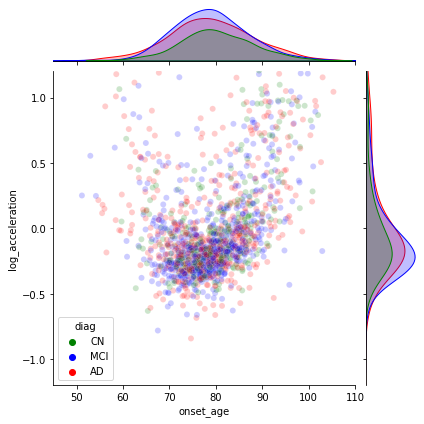

In [30]:
import seaborn as sns

sns.jointplot(data = ip,
                x = 'onset_age', 
                y = 'log_acceleration', 
                hue = 'diag',
                hue_order = ['CN', 'MCI', 'AD'],
                alpha=0.2, 
                palette = ['g', 'b', 'r'],
                xlim = (45,110),
                ylim = (-1.2,1.2))

plt.show()

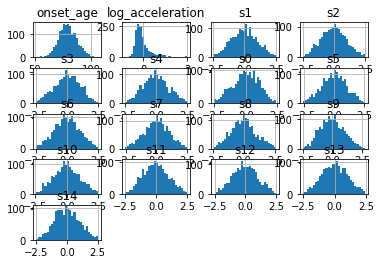

In [31]:
ip.hist(bins=30)
plt.show()

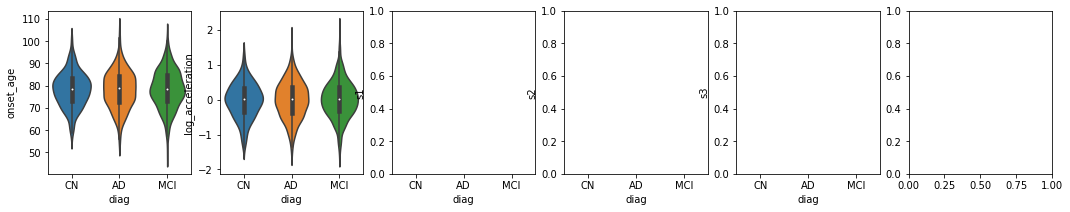

In [33]:
columns = ip.columns
fig, axes = plt.subplots(1,6, figsize=(18,3))

for i in range(5):
    sns.violinplot(x='diag', y=columns[i], data=ip, ax=axes[i])

## Extrapolate one patient's trajectory

In [41]:
data['RID'][24:27]

tensor([4225, 4225, 4225])

In [36]:
for sub in ip.index.unique():
    sub_data = ip.loc[sub]
    if len(sub_data)>6:
        if 'AD' in sub_data.values:
            if sub==4225:
                print(sub)

4225


Onset age is 82.189068 and log_acceleration is -0.288008


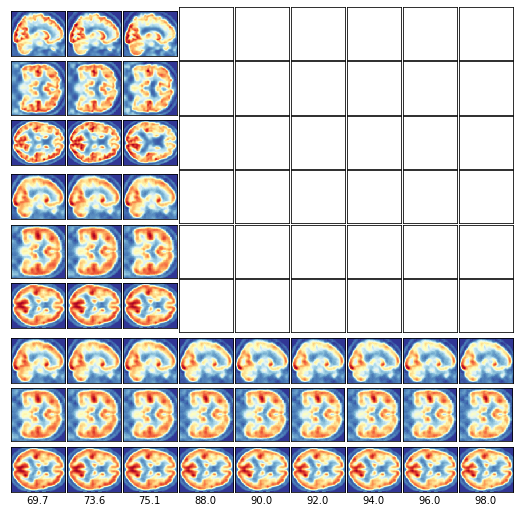

In [46]:
model.CAE.to(device)

sub_idx = 24
nb_visits = 3
prediction_timepoints = [88, 90, 92, 94, 96, 98]

fig, axes = plt.subplots(nrows=9, ncols=9, figsize=(9,9))
plt.subplots_adjust(wspace=0.03, hspace=0.02)

onset_age, log_acceleration, source = individual_RER['onset_age'][int(data['labels'][sub_idx])], individual_RER['log_acceleration'][int(data['labels'][sub_idx])], individual_RER['sources'][int(data['labels'][sub_idx])]
print(f"Onset age is {onset_age} and log_acceleration is {log_acceleration}")

for i in range(9):
    if i < nb_visits:
        axes[0][i].matshow(np.rot90(data['data'][sub_idx+i][30]), cmap='RdYlBu_r')
        axes[1][i].matshow(data['data'][sub_idx+i][:,44], cmap='RdYlBu_r')
        axes[2][i].matshow(data['data'][sub_idx+i][:,:,40], cmap='RdYlBu_r')
        
        reconstructed = model.CAE.decoder(torch.FloatTensor(model.full_encoded[sub_idx+i].unsqueeze(0)).to(device))
        reconstructed = reconstructed.cpu().detach().numpy()[0]
        axes[3][i].matshow(np.rot90(reconstructed[0][30]), cmap='RdYlBu_r')
        axes[4][i].matshow(reconstructed[0][:,44], cmap='RdYlBu_r')
        axes[5][i].matshow(reconstructed[0][:,:,40], cmap='RdYlBu_r')
        
        timepoint = data['timepoints'][38+i]
        reparametrized_age = np.exp(log_acceleration) * (timepoint - onset_age) + individual_RER['onset_age'].mean()
        expected_position = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([reparametrized_age]).to(device), sources=torch.FloatTensor(source).to(device))
        expected_image = model.CAE.decoder(expected_position.unsqueeze(0))
        expected_image = expected_image.cpu().detach().numpy()[0]
        axes[6][i].matshow(np.rot90(expected_image[0][30]), cmap='RdYlBu_r')
        axes[7][i].matshow(expected_image[0][:,44], cmap='RdYlBu_r')
        axes[8][i].matshow(expected_image[0][:,:,40], cmap='RdYlBu_r')
            
    else:
        reparametrized_age = prediction_timepoints[i - nb_visits]
        expected_position = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([reparametrized_age]).to(device), sources=torch.FloatTensor(source).to(device))
        expected_image = model.CAE.decoder(expected_position.unsqueeze(0))
        expected_image = expected_image.cpu().detach().numpy()[0]
        axes[6][i].matshow(np.rot90(expected_image[0][30]), cmap='RdYlBu_r')
        axes[7][i].matshow(expected_image[0][:,44], cmap='RdYlBu_r')
        axes[8][i].matshow(expected_image[0][:,:,40], cmap='RdYlBu_r')
        
    axes[8][i].set_xlabel(np.around(float(reparametrized_age),1))

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

## Distribution of encoded representations

In [61]:
encoded_df = pd.DataFrame(model.full_encoded, dtype=np.float)

/tmp/ipykernel_416488/417019401.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  encoded_df = pd.DataFrame(model.full_encoded, dtype=np.float)


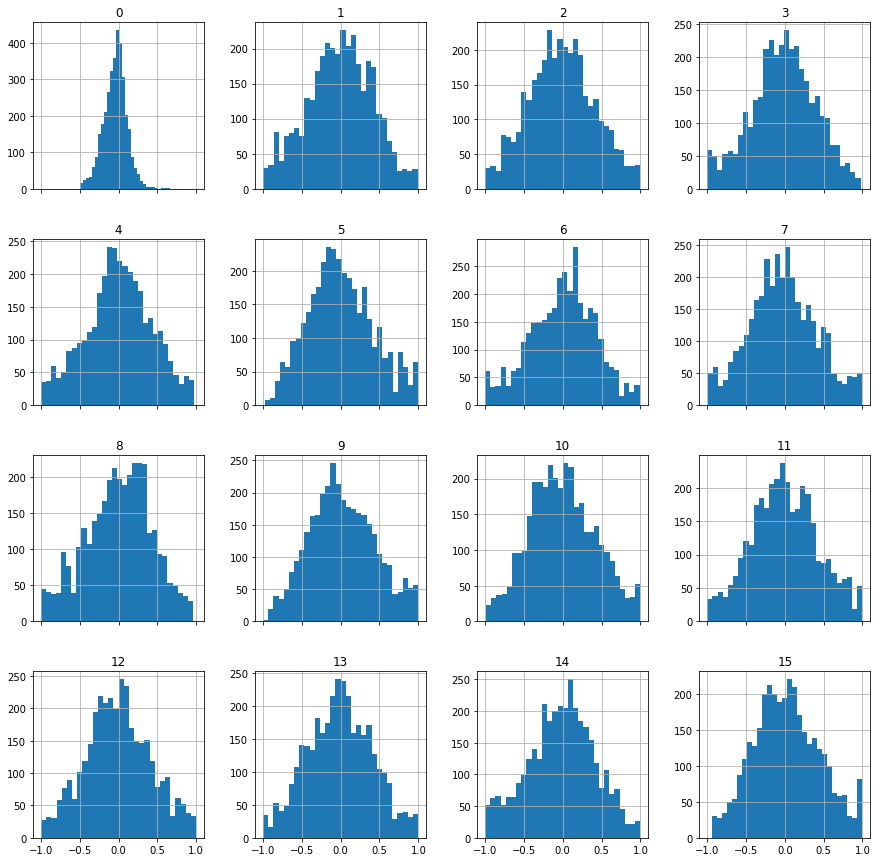

In [62]:
encoded_df.hist(bins=30, figsize=(15,15), sharex=True)
plt.show()

## Plot the freesurfer volumes with reparametrized age

In [63]:
df = df.loc[ip.index]

df['t_hat'] = np.exp(ip.loc[df.index]['log_acceleration']) * (df['TIME'] - ip.loc[df.index]['onset_age']) + 72.5
df['ID'] = df.index
test = df.set_index(['ID','TIME'])

<AxesSubplot:xlabel='t_hat', ylabel='Count'>

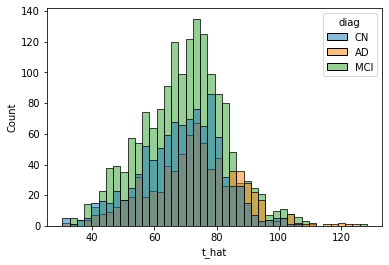

In [64]:
df['ID'] = df.index
test = df.set_index(['ID','TIME'])
test = test[~test.index.duplicated(keep='first')]
test = test[test['t_hat'].between(30,130)]

sns.histplot(data=test, x='t_hat', hue='diag')

<AxesSubplot:xlabel='diag', ylabel='t_hat'>

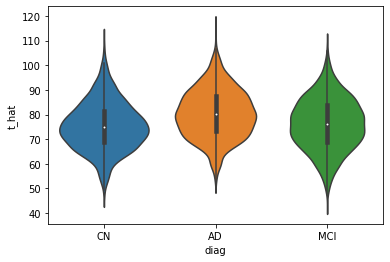

In [147]:
sns.violinplot(data=test, y='t_hat', x='diag')

<AxesSubplot:xlabel='diag', ylabel='t_hat'>

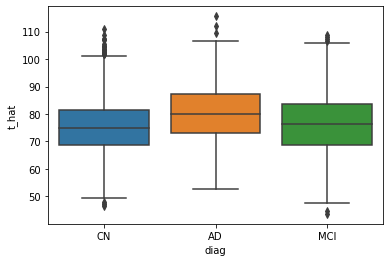

In [148]:
sns.boxplot(data=test, y='t_hat', x='diag')

In [150]:
columns = ["RID","AGE_vis","MES_MRI_HIPPOCAMPUS_ICV","MES_MRI_VENTRICLES_ICV", "DX"]
img_data = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/leaspy/clean/2021-05-25/ADNI_leaspy_ready.csv', usecols=columns,
                       sep=',', error_bad_lines=False)
img_data.rename(columns={'RID':'ID', 'AGE_vis':'TIME', 'DX':'diag'}, inplace=True)
img_data = img_data.set_index('ID')

In [151]:
img_data = img_data.loc[ip.index]
img_data = img_data.dropna()

img_data['t_hat'] = np.exp(ip.loc[img_data.index]['log_acceleration']) * (img_data['TIME'] - ip.loc[img_data.index]['onset_age']) + 72.5
img_data = img_data[img_data['t_hat'].between(30,130)]

<AxesSubplot:xlabel='t_hat', ylabel='MES_MRI_HIPPOCAMPUS_ICV'>

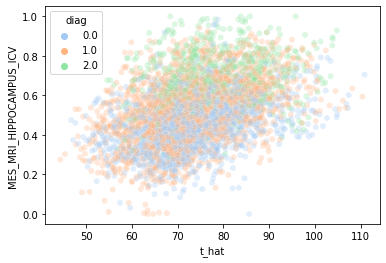

In [157]:
sns.scatterplot(data=img_data, x='t_hat', y='MES_MRI_HIPPOCAMPUS_ICV', hue='diag', alpha=.3, palette='pastel')

<AxesSubplot:xlabel='t_hat', ylabel='MES_MRI_VENTRICLES_ICV'>

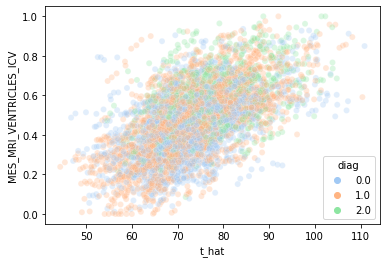

In [153]:
sns.scatterplot(data=img_data, x='t_hat', y='MES_MRI_VENTRICLES_ICV', hue='diag', alpha=.3, palette='pastel')

<AxesSubplot:xlabel='MES_MRI_HIPPOCAMPUS_ICV', ylabel='MES_MRI_VENTRICLES_ICV'>

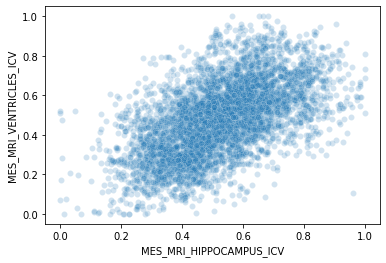

In [156]:
sns.scatterplot(data=img_data, x='MES_MRI_HIPPOCAMPUS_ICV', y='MES_MRI_VENTRICLES_ICV', alpha=.2)

<AxesSubplot:xlabel='t_hat', ylabel='MMSE'>

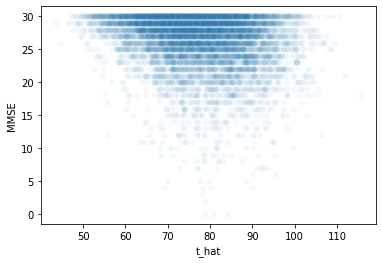

In [155]:
sns.scatterplot(data=df, x='t_hat', y='MMSE', alpha=.05)

## Statistical tests to link ip with covariates

In [92]:
from scipy.stats import mannwhitneyu

In [93]:
sex = caps_info[~caps_info.index.duplicated(keep='first')]['sex']
ip = ip.merge(sex, on='ID')

In [94]:
onset_men = ip.loc[ip['sex']=='M']['onset_age']
onset_women = ip.loc[ip['sex']=='F']['onset_age']

_,p = mannwhitneyu(onset_women, onset_men)

print(f"Onset age for men is {onset_men.mean():.4f} and for women {onset_women.mean():.4f} wich differs with pvalue : {p}")

Onset age for men is 76.9186 and for women 77.1426 wich differs with pvalue : 0.39395503190992653


In [54]:
xi_men = ip.loc[ip['sex']=='M']['log_acceleration']
xi_women = ip.loc[ip['sex']=='F']['log_acceleration']

_, p = mannwhitneyu(xi_women, xi_men)

print(f"Xi for men is {xi_men.mean():.4f} and for women {xi_women.mean():.4f} wich differs with pvalue : {p}")

Xi for men is 0.0034 and for women -0.0042 wich differs with pvalue : 0.4714627838007727


In [55]:
apoe = caps_info[~caps_info.index.duplicated(keep='first')]['apoe4'].dropna()
ip = ip.merge(apoe, on='ID')

In [70]:
onset_cn = ip.loc[ip['apoe4']==0]['onset_age']
onset_apoe = ip.loc[ip['apoe4']!=0]['onset_age']

_,p = mannwhitneyu(onset_cn, onset_apoe)

print(f"Onset age for non-APOE carriers is {onset_cn.mean():.4f} and for carriers {onset_apoe.mean():.4f} wich differs with pvalue : {p}")

Onset age for non-APOE carriers is 76.2757 and for carriers 75.7691 wich differs with pvalue : 0.25563713056767867


In [189]:
xi_cn = ip.loc[ip['apoe4']==0]['log_acceleration']
xi_apoe = ip.loc[ip['apoe4']!=0]['log_acceleration']

_,p = mannwhitneyu(xi_cn, xi_apoe)

print(f"Xi for non-APOE carriers is {xi_cn.mean():.4f} and for carriers {xi_apoe.mean():.4f} wich differs with pvalue : {p}")

Xi for non-APOE carriers is -0.0175 and for carriers 0.0124 wich differs with pvalue : 0.1774724666329291


## Evaluation of MCMC convergence

In [54]:
rer = np.load('output_CVAE_16_1_source_full/LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
#trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
 #      allow_pickle=True)[()]
ids = pd.read_csv('output_CVAE_16_1_source_full/LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

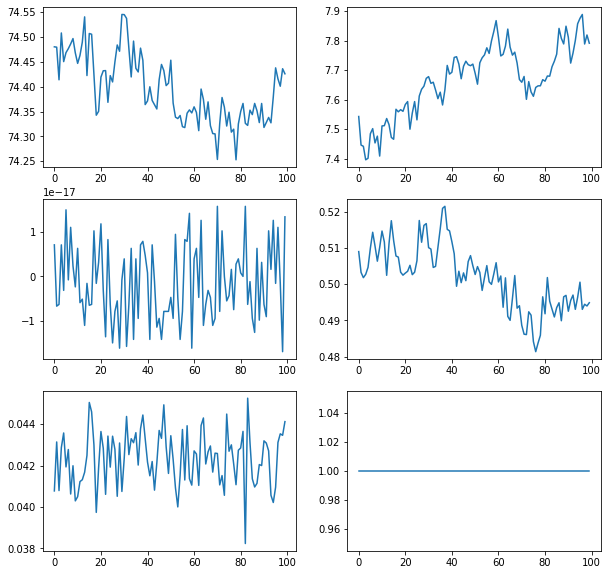

In [55]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

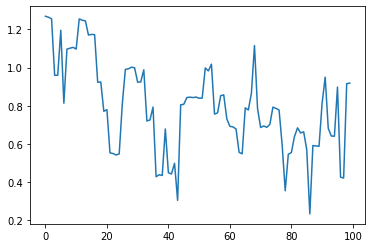

In [57]:
plt.plot(rer['log_acceleration'][:,40])

## How much every latent dimension contributes to the temporal variation

In [71]:
encoded = pd.DataFrame(model.full_encoded).astype('float')
encoded['ID'] = model.full_labels
encoded['TIME'] = model.full_timepoints
encoded = encoded.set_index('ID')

In [72]:
variation = pd.DataFrame(index=encoded.index.unique(), columns=encoded.columns)

for sub in encoded.index.unique():
    encoded_sub = encoded.loc[sub]
    if type(encoded_sub) != pd.core.series.Series:
        visit_1 = encoded_sub.iloc[0]
        visit_2 = encoded_sub.iloc[-1]
        variation.loc[sub] = visit_2 - visit_1
    else:
        variation.drop(sub)
        
variation = variation.astype('float').dropna().drop('TIME', axis=1)
variation['total_variation'] = np.sqrt((variation**2).sum(axis=1))
variation = variation.div(variation['total_variation'], axis=0)
variation = variation**2

In [73]:
variation.describe()

0             1             2             3             4  \
count  8.150000e+02  8.150000e+02  8.150000e+02  8.150000e+02  8.150000e+02   
mean   2.601304e-01  4.552451e-02  4.844075e-02  4.674155e-02  4.962567e-02   
std    2.587535e-01  7.040846e-02  6.916053e-02  7.418253e-02  7.870940e-02   
min    6.368736e-07  2.903430e-07  5.229384e-11  4.920929e-08  4.272474e-09   
25%    3.837425e-02  4.450991e-03  3.505152e-03  3.076252e-03  3.110055e-03   
50%    1.787796e-01  1.943640e-02  2.052469e-02  1.665691e-02  1.843897e-02   
75%    4.244588e-01  5.593508e-02  6.227846e-02  5.598312e-02  5.976047e-02   
max    9.612076e-01  6.389258e-01  5.863067e-01  5.589194e-01  6.139590e-01   

                  5             6             7             8             9  \
count  8.150000e+02  8.150000e+02  8.150000e+02  8.150000e+02  8.150000e+02   
mean   4.963471e-02  5.211296e-02  4.993286e-02  5.048073e-02  4.673339e-02   
std    7.789647e-02  8.183223e-02  7.544385e-02  7.674414e-02  7.317527e-02   
min    1.398903e-08  2.019712e-08  2.570582e-08  1.394994e-09  6.986202e-09   
25%    3.182408e-03  4.074488e-03  4.540680e-03  4.437188e-03  3.629618e-03   
50%    1.714775e-02  1.741366e-02  1.873774e-02  1.833304e-02  1.676952e-02   
75%    6.323777e-02  6.409535e-02  6.310231e-02  6.536464e-02  5.368282e-02   
max    5.805307e-01  6.118869e-01  5.938643e-01  5.988261e-01  5.159547e-01   

                 10            11            12            13            14  \
count  8.150000e+02  8.150000e+02  8.150000e+02  8.150000e+02  8.150000e+02   
mean   5.125387e-02  4.945399e-02  4.914900e-02  4.534314e-02  5.244509e-02   
std    8.294216e-02  7.784179e-02  7.772858e-02  7.095491e-02  7.874498e-02   
min    1.294119e-07  8.911295e-07  1.922341e-08  1.668342e-11  5.390762e-08   
25%    3.360587e-03  3.661823e-03  3.580613e-03  3.171937e-03  3.685838e-03   
50%    1.733867e-02  1.706371e-02  1.794142e-02  1.650126e-02  1.966473e-02   
75%    6.175703e-02  5.987886e-02  5.857496e-02  5.531619e-02  6.708548e-02   
max    6.789817e-01  6.382360e-01  5.579373e-01  4.852666e-01  5.885379e-01   

                 15  total_variation  
count  8.150000e+02            815.0  
mean   5.299743e-02              1.0  
std    8.143056e-02              0.0  
min    1.371609e-10              1.0  
25%    3.778735e-03              1.0  
50%    1.874403e-02              1.0  
75%    6.769268e-02              1.0  
max    5.411896e-01              1.0

## Univariate MMSE to compare the indiviudal parameters

In [158]:
MMSE = caps_info.loc[ip.index][['TIME','MMSE']].dropna()
MMSE['MMSE'] = MMSE['MMSE']/30
MMSE['MMSE'] = 1 - MMSE['MMSE'] 

In [159]:
# import leaspy

path_leaspy = '/home/benoit.sautydechalon/leaspy/'
sys.path.append(path_leaspy)

from leaspy import Leaspy, Data, IndividualParameters, AlgorithmSettings

In [160]:
# Settings
n_iter = 8000
settings = AlgorithmSettings('mcmc_saem', n_iter=n_iter)

# Fitting the model

leaspy = Leaspy('univariate_logistic')
data_leaspy = Data.from_dataframe(MMSE)
leaspy.fit(data_leaspy, settings)

settings_2 = AlgorithmSettings('scipy_minimize', n_jobs=30)
individual_parameters = leaspy.personalize(data_leaspy, settings_2)
ip_mmse = individual_parameters.to_dataframe()
ip_mmse.index = [int(sub) for sub in ip_mmse.index]
ip_mmse.index.name = 'ID'

|##################################################|   8000/8000 iterations
Fit with `mcmc_saem` took: 1m 18s
The standard deviation of the noise at the end of the fit is:
4.65%
|##############################################----|   1932/2143 subjectss
Personalize with `scipy_minimize` took: 49s
The standard deviation of the noise at the end of the personalize is:
3.99%


In [170]:
ip_mmse.mean()

xi     6.299726e-17
tau    7.268634e+01
dtype: float64

In [171]:
ip_mmse['xi'] = ip_mmse['xi'] - ip_mmse['xi'].mean()
ip_mmse = ip_mmse - ip_mmse.mean()
ip_mmse = ip_mmse / ip_mmse.std()
ip_mmse.head()

xi       tau
ID                     
295  1.089109  1.815988
413 -0.091685  2.469406
559 -0.157160  1.427887
619 -0.133353 -1.042112
685 -2.016143  1.061690

In [172]:
ip_lvae = ip[['onset_age', 'log_acceleration']]
ip_lvae.columns = ['tau_vae', 'xi_vae']
ip_lvae = ip_lvae - ip_lvae.mean()
ip_lvae = ip_lvae / ip_lvae.std()
ip_lvae.head()

tau_vae    xi_vae
ID                     
295  1.042779 -0.135639
413  2.482872 -0.856525
559 -0.272466  0.902430
619 -0.403393  1.793272
685  0.877424  0.648167

In [174]:
ip_total = ip_img.merge(ip_lvae, on='ID')
ip_total.corr()

xi       tau  sources_0   tau_vae    xi_vae
xi         1.000000 -0.218027  -0.146774 -0.124310  0.072070
tau       -0.218027  1.000000   0.061641  0.333631 -0.025896
sources_0 -0.146774  0.061641   1.000000 -0.142444  0.035439
tau_vae   -0.124310  0.333631  -0.142444  1.000000 -0.032480
xi_vae     0.072070 -0.025896   0.035439 -0.032480  1.000000

### Link between MMSE and freesurfer

In [175]:
ip_total = ip_img.merge(ip_mmse, on='ID')
ip_total.corr()

xi_x     tau_x  sources_0      xi_y     tau_y
xi_x       1.000000 -0.218027  -0.146774  0.377241 -0.249951
tau_x     -0.218027  1.000000   0.061641 -0.339666  0.431316
sources_0 -0.146774  0.061641   1.000000 -0.129589  0.151292
xi_y       0.377241 -0.339666  -0.129589  1.000000 -0.094581
tau_y     -0.249951  0.431316   0.151292 -0.094581  1.000000

## Multivariate on hippocampus and ventricles to compare

In [165]:
columns = ['RID','AGE_vis', 'MES_MRI_HIPPOCAMPUS_ICV','MES_MRI_VENTRICLES_ICV', 'MES_MRI_AMYGDALA_ICV']
img_data = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/leaspy/clean/2021-05-25/ADNI_leaspy_ready.csv', 
                   usecols=columns, sep=',', error_bad_lines=False)
img_data.rename(columns={'RID':'ID', 'AGE_vis':'TIME'}, inplace=True)
img_data = img_data.set_index('ID')

In [167]:
# Settings
n_iter = 8000
n_sources = 1
settings = AlgorithmSettings('mcmc_saem', n_iter=n_iter)

# Fitting the model

leaspy = Leaspy('logistic')
leaspy.model.load_hyperparameters({'source_dimension': n_sources})
data_leaspy = Data.from_dataframe(img_data)
leaspy.fit(data_leaspy, settings)

settings_2 = AlgorithmSettings('scipy_minimize', n_jobs=30)
individual_parameters = leaspy.personalize(data_leaspy, settings_2)
ip_img = individual_parameters.to_dataframe()
ip_img.index = [int(sub) for sub in ip_img.index]
ip_img.index.name = 'ID'

|##################################################|   8000/8000 iterations
Fit with `mcmc_saem` took: 8m 22s
The standard deviation of the noise at the end of the fit is:
MES_MRI_AMYGDALA_ICV: 9.03%
MES_MRI_HIPPOCAMPUS_ICV: 3.22%
MES_MRI_VENTRICLES_ICV: 2.08%
|##################################################|   1550/1568 subjects
Personalize with `scipy_minimize` took: 42s
The standard deviation of the noise at the end of the personalize is:
MES_MRI_AMYGDALA_ICV: 8.92%
MES_MRI_HIPPOCAMPUS_ICV: 2.70%
MES_MRI_VENTRICLES_ICV: 1.64%


In [168]:
ip_total = ip_img.merge(ip_lvae, on='ID')
ip_total.corr()

xi       tau  sources_0   tau_vae    xi_vae
xi         1.000000 -0.218027  -0.146774 -0.124310  0.072070
tau       -0.218027  1.000000   0.061641  0.333631 -0.025896
sources_0 -0.146774  0.061641   1.000000 -0.142444  0.035439
tau_vae   -0.124310  0.333631  -0.142444  1.000000 -0.032480
xi_vae     0.072070 -0.025896   0.035439 -0.032480  1.000000

## Predicting freesurfer volumes from latent space encodings

In [55]:
encoded = pd.DataFrame(model.full_encoded).astype('float')
encoded['ID'] = model.full_labels
encoded['TIME'] = model.full_timepoints
encoded = encoded.set_index(['ID','TIME'])

In [57]:
columns = ["RID","AGE_vis","MES_MRI_HIPPOCAMPUS_ICV","MES_MRI_VENTRICLES_ICV", "DX"]
img_data = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/leaspy/clean/2021-05-25/ADNI_leaspy_ready.csv', usecols=columns,
                       sep=',', error_bad_lines=False)
img_data.rename(columns={'RID':'ID', 'AGE_vis':'TIME', 'DX':'diag'}, inplace=True)
img_data = img_data.round({'TIME':1})
img_data = img_data.set_index(['ID','TIME'])

In [58]:
img_data

diag  MES_MRI_HIPPOCAMPUS_ICV  MES_MRI_VENTRICLES_ICV
ID   TIME                                                       
2    74.4   0.0                      NaN                     NaN
     74.9   0.0                      NaN                     NaN
     77.4   0.0                      NaN                     NaN
     79.4   0.0                      NaN                     NaN
     80.4   0.0                      NaN                     NaN
...         ...                      ...                     ...
6915 63.3   0.0                      NaN                     NaN
6916 77.1   1.0                      NaN                     NaN
6918 57.4   0.0                      NaN                     NaN
6921 76.6   2.0                      NaN                     NaN
6924 60.2   0.0                      NaN                     NaN

[13219 rows x 3 columns]

In [59]:
img_data.dropna()

diag  MES_MRI_HIPPOCAMPUS_ICV  MES_MRI_VENTRICLES_ICV
ID   TIME                                                       
15   82.9   0.0                 0.534857                0.471768
21   77.6   0.0                 0.377238                0.292681
     78.6   0.0                 0.412620                0.348860
     79.6   0.0                 0.380280                0.332652
     80.6   0.0                 0.439737                0.324140
...         ...                      ...                     ...
6850 79.7   2.0                 0.771166                0.695320
6852 76.4   1.0                 0.433353                0.538021
6853 67.1   0.0                 0.328279                0.162305
6857 71.4   1.0                 0.367380                0.368481
6860 74.8   1.0                 0.406641                0.261544

[4947 rows x 3 columns]

In [60]:
encoded.dropna()

0         1         2         3         4         5   \
ID  TIME                                                               
0   77.5  0.068762  0.151090  0.465223  0.141576  0.016701  0.916617   
    78.0  0.085480  0.167077  0.467609  0.116165  0.030402  0.927777   
    78.5  0.125810  0.159420  0.450733  0.121853  0.013550  0.924574   
    79.6  0.140824  0.145564  0.446790  0.113195  0.060547  0.932766   
1   65.1 -0.357891 -0.602206  0.794056 -0.131810 -0.174257 -0.259900   
...            ...       ...       ...       ...       ...       ...   
781 70.6  0.423972  0.199434  0.095562 -0.004338 -0.077559  0.108698   
    71.1  0.377795  0.196743  0.128506  0.142093 -0.148432  0.111694   
782 69.7 -0.180335 -0.158831 -0.204758  0.154189 -0.284307  0.031193   
783 79.3  0.114228  0.221217 -0.083940 -0.065659  0.242654 -0.070365   
    80.3  0.089444  0.244680 -0.037204  0.027182  0.174969 -0.104967   

                6         7         8         9         10        11  \
ID  TIME                                                               
0   77.5  0.314865  0.284203 -0.052482  0.159666  0.785807  0.042716   
    78.0  0.320843  0.304233 -0.054954  0.171938  0.818336  0.045158   
    78.5  0.298476  0.301612 -0.044425  0.137609  0.811839  0.046372   
    79.6  0.320925  0.295805 -0.038954  0.158547  0.834921  0.022269   
1   65.1  0.178848  0.194217  0.217493 -0.688248  0.863456 -0.821777   
...            ...       ...       ...       ...       ...       ...   
781 70.6  0.110696 -0.209205 -0.125518 -0.173478 -0.209324 -0.055008   
    71.1  0.059604 -0.197830 -0.148255 -0.179516  0.038276 -0.175603   
782 69.7 -0.302135  0.208877 -0.171702 -0.022218  0.115717  0.131585   
783 79.3  0.061561  0.079090  0.051630  0.175421 -0.141401  0.343854   
    80.3  0.116485  0.075099  0.050074  0.099765 -0.168729  0.330886   

                12        13        14        15  
ID  TIME                                          
0   77.5 -0.232332  0.880526  0.741168  0.841288  
    78.0 -0.239043  0.907544  0.761880  0.872396  
    78.5 -0.234482  0.913717  0.736949  0.871762  
    79.6 -0.252224  0.920417  0.750687  0.884760  
1   65.1  0.529012 -0.947485  0.011592 -0.256265  
...            ...       ...       ...       ...  
781 70.6 -0.118990 -0.035079  0.150183 -0.100201  
    71.1 -0.072362 -0.043947  0.181875 -0.187781  
782 69.7 -0.085201  0.058881  0.059228 -0.037303  
783 79.3 -0.046310  0.132545 -0.050591 -0.117127  
    80.3  0.001362  0.270898 -0.059235 -0.058627  

[3685 rows x 16 columns]

In [ ]:
subs

[(259, 83.2)]

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

feat = 'MES_MRI_VENTRICLES_ICV'

X = encoded.dropna()
y = img_data[feat].dropna()

subs = [sub for sub in X.index if sub in y.index]
X, y = X.loc[subs], y.loc[subs]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train -= X_train.mean()
X_train /= X_train.std()
X_test -= X_test.mean()
X_test /= X_test.std()
#y_train -= y_train.mean()
#y_train /= y_train.std()
#y_test -= y_test.mean()
#y_test /= y_test.std()

NotImplementedError: Index._join_level on non-unique index is not implemented

In [42]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=1, gamma='auto', epsilon=.1)
svr_lin = SVR(kernel='linear', C=1, gamma=0.1)
svr_poly = SVR(kernel='poly', C=1, gamma=0.1, degree=3, epsilon=.1,
               coef0=1)

svrs = [svr_rbf, svr_lin, svr_poly]

for svr in svrs:
    print(svr)
    regr = svr.fit(X_train,y_train)
    
    y_pred = pd.DataFrame(regr.predict(X_train))
    y_pred.index = X_train.index
    y_pred.columns = [feat]

    y_pred_t = pd.DataFrame(regr.predict(X_test))
    y_pred_t.index = X_test.index
    y_pred_t.columns = [feat]

    print(f"train error = {np.sqrt(mean_squared_error(y_pred, y_train))}")
    print(f"test error = {np.sqrt(mean_squared_error(y_pred_t, y_test))}")
    print(f"r2 train = {r2_score(y_train,y_pred)}")
    print(f"r2 test = {r2_score(y_test,y_pred_t)}")

SVR(C=1, gamma='auto')
train error = 0.0877206132764918
test error = 0.20623556485172514
r2 train = 0.6750580921019315
r2 test = -1.3168174258179626
SVR(C=1, gamma=0.1, kernel='linear')
train error = 0.08342224480668092
test error = 0.2047932132403799
r2 train = 0.7061226251504666
r2 test = -1.2845244502439694
SVR(C=1, coef0=1, gamma=0.1, kernel='poly')
train error = 0.08732371046946318
test error = 0.229555811362826
r2 train = 0.6779919198390187
r2 test = -1.8703924131674707


/tmp/ipykernel_3026456/2485387707.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for depth in tqdm_notebook(grid_search):


  0%|          | 0/19 [00:00<?, ?it/s]

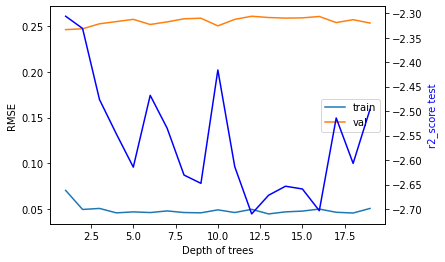

In [43]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

train_losses = []
test_losses = []
R2_lst = []
grid_search = range(1,20)

for depth in tqdm_notebook(grid_search):
    
    train_loss = 0
    test_loss = 0
    R2 = 0
    for i in range(10):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        X_train -= X_train.mean()
        X_train /= X_train.std()
        X_test -= X_test.mean()
        X_test /= X_test.std()

        regr = RandomForestRegressor(max_depth=depth).fit(X_train,y_train)

        y_pred = pd.DataFrame(regr.predict(X_train))
        y_pred.index = X_train.index
        y_pred.columns = [feat]

        y_pred_t = pd.DataFrame(regr.predict(X_test))
        y_pred_t.index = X_test.index
        y_pred_t.columns = [feat]

        train_loss += np.sqrt(mean_squared_error(y_pred, y_train))
        test_loss += np.sqrt(mean_squared_error(y_pred_t, y_test))
        R2 += regr.score(X_test,y_test)


    train_losses.append(train_loss/10)
    test_losses.append(test_loss/10)
    R2_lst.append(R2/10)
       

fig, ax1 = plt.subplots()
ax1.set_xlabel('Depth of trees')
ax1.set_ylabel('RMSE')
ax1.plot(grid_search, train_losses, label='train')
ax1.plot(grid_search, test_losses, label='val')
ax1.legend()
ax1.tick_params(axis='y')

ax2 = ax1.twinx() 
ax2.set_ylabel('r2_score test', c='b')  
ax2.plot(grid_search, R2_lst, c='b')
ax2.tick_params(axis='y')

## Tools for figures

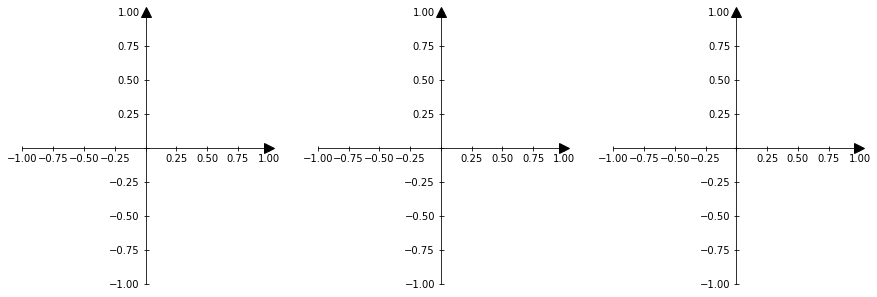

In [94]:
rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
      "xtick.major.size" : 5, "ytick.major.size" : 5,}
with plt.rc_context(rc):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    for i in range(3):
        ax[i].plot()

        ax[i].spines['left'].set_position('zero')
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_position('zero')
        ax[i].spines['top'].set_visible(False)
        ax[i].xaxis.set_ticks_position('bottom')
        ax[i].yaxis.set_ticks_position('left')

        # make arrows
        ax[i].plot((1), (0), ls="", marker=">", ms=10, color="k",
                transform=ax[i].get_yaxis_transform(), clip_on=False)
        ax[i].plot((0), (1), ls="", marker="^", ms=10, color="k",
                transform=ax[i].get_xaxis_transform(), clip_on=False)

        ax[i].yaxis.get_major_ticks()[4].label1.set_visible(False)
        ax[i].xaxis.get_major_ticks()[4].label1.set_visible(False)

        ax[i].set_xlim([-1, 1])
        ax[i].set_ylim([-1, 1])
    
    plt.show()

In [17]:
ax[i].yax[i]is.get_major_ticks()[1]

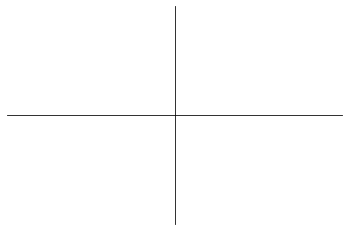

In [100]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xticks([])
plt.yticks([])

plt.plot()
plt.show()

## Data-analysis on the encoded images

In [7]:
encoded = torch.load('../deformetrica/deformetrica/LAE_experiments/encoded_datasetCAE_300_epochs_5e-5_lr')

In [32]:
data = encoded['data']

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [28]:
data = scale(data)

In [27]:
data.mean()

tensor(0.5189)

In [33]:
covar_matrix = PCA(n_components = 20)

In [34]:
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features


array([68.7, 72.7, 74.1, 75. , 75.6, 76.1, 76.6, 77. , 77.3, 77.6, 77.9,
       78.2, 78.5, 78.8, 79.1, 79.3, 79.5, 79.7, 79.9, 80.1])

## Data-analysis on the true images

In [26]:
data = torch.load('ADNI_small')

In [27]:
data = data['data']

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [33]:
data = (data-data.mean())/data.std()

In [34]:
covar_matrix = PCA(n_components = 20)

In [36]:
n_samples, nx, ny, nz = data.shape
data = data.reshape((n_samples, nx*ny*nz))

covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([13.5, 19.2, 22.9, 24.8, 26.6, 28.2, 29.7, 30.9, 32. , 33.1, 34.1,
       35. , 35.7, 36.4, 37.1, 37.8, 38.4, 39. , 39.5, 40. ])